In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
def process_data(df):
    # process the data
    # the first 32 rows are the metadata
    metadata = df.iloc[:32,:2]
    metadata = metadata.T.reset_index(drop=True)
    metadata.columns = metadata.iloc[0]
    metadata = metadata.iloc[1:]

    # the rest is the data
    data = df.iloc[33:]
    # make the columns the first row
    data.columns = data.iloc[0]
    units = data.iloc[1]
    data = data.iloc[2:]
    data = data.reset_index(drop=True)
    data = data.replace('-', np.nan)
    # make a arm column
    arms = data[[x for x in data.columns if 'In zone' in x]]
    arms = arms.iloc[:,1:]
    # for each row, find the column with the max value after filling the NaNs with 0
    arms = arms.fillna(-1).astype(float)
    arms = arms.idxmax(axis=1)
    arms = arms.str.replace('Center Stage', 'Arm0')
    arms = arms.fillna(-1)
    # convert to int
    converter = lambda x: int(x.replace('In zone(Arm', '').replace(' / center-point)', '')) if x != -1 else -1
    arms = arms.apply(converter).values
    # clean the data
    # cleaning rules:
    # if there is a stretch of -1s, with the same value before and after, replace the -1s with that value
    # if there is a stretch of -1s, with different values before and after, replace the -1s with the value with 0
    # if there is a stretch of -1s at the beginning or the end of the array, do nothing

    # loop through the array
    in_stretch = False
    stretch_start = 0
    for i in range(len(arms)):
        if arms[i] == -1 and not in_stretch:
            in_stretch = True
            stretch_start = i
        elif arms[i] == -1 and in_stretch:
            pass
        else:
            if in_stretch:
                if stretch_start == 0 or i == len(arms):
                    # at the beginning or the end (do nothing)
                    pass
                else:
                    # in the middle
                    if arms[stretch_start-1] == arms[i]:
                        arms[stretch_start:i] = arms[stretch_start-1]
                    else:
                        arms[stretch_start:i] = 0
                in_stretch = False
            else:
                pass

    # get encounter durations from arms
    times = data['Trial time'].values
    stretch_start = 0
    stretch_start_time = times[0]
    current_state = arms[0]


    encounter_states = []
    encounter_durations = []
    current_encounter_no = [0]
    for i in range(1,len(arms)):
        if arms[i] != current_state:
            # encounter ended
            encounter_states.append(current_state)
            encounter_durations.append(times[i] - stretch_start_time)
            current_state = arms[i]
            stretch_start_time = times[i]
            stretch_start = i
        else:
            pass
        current_encounter_no.append(len(encounter_states))

    # add the last state
    encounter_states.append(current_state)
    encounter_durations.append(times[-1] - stretch_start_time)

    # convert to numpy arrays
    encounter_states = np.array(encounter_states)
    encounter_durations = np.array(encounter_durations)
    current_encounter_no = np.array(current_encounter_no)
    current_encounter_duration = np.zeros(len(arms))
    for i in range(len(encounter_states)):
        current_encounter_duration[current_encounter_no == i] = encounter_durations[i]

    # set the arms with < 1s duration to 0
    arms[np.logical_and(np.logical_and(arms != -1, arms != 0), current_encounter_duration < 1)] = 0
    # recalculate the encounter durations
    stretch_start = 0
    stretch_start_time = times[0]
    current_state = arms[0]

    encounter_states = []
    encounter_durations = []
    current_encounter_no = [0]
    for i in range(1,len(arms)):
        if arms[i] != current_state:
            # encounter ended
            encounter_states.append(current_state)
            encounter_durations.append(times[i] - stretch_start_time)
            current_state = arms[i]
            stretch_start_time = times[i]
            stretch_start = i
        else:
            pass
        current_encounter_no.append(len(encounter_states))

    # add the last state
    encounter_states.append(current_state)
    encounter_durations.append(times[-1] - stretch_start_time)

    # convert to numpy arrays
    encounter_states = np.array(encounter_states)
    encounter_durations = np.array(encounter_durations)
    current_encounter_no = np.array(current_encounter_no)
    current_encounter_duration = np.zeros(len(arms))
    for i in range(len(encounter_states)):
        current_encounter_duration[current_encounter_no == i] = encounter_durations[i]

    # add the arms, encounter number and encounter duration to the data
    data['Arm'] = arms
    data['Encounter number'] = current_encounter_no
    data['Encounter duration'] = current_encounter_duration

    return data, metadata


In [3]:
# function to find novel sequences
def novel_sequence_finder(arm_sequence):
    novel_sequences = []
    novel_sequences_start = []
    novel_sequences_end = []
    past_set = set()
    index = 0
    i = 1
    while i < len(arm_sequence):
        new_set = set(arm_sequence[index:i])
        if len(new_set) > len(past_set):
            past_set = new_set
        else:
            # end of the sequence
            past_sequence = arm_sequence[index:i-1]
            novel_sequences.append(past_sequence)
            novel_sequences_start.append(index)
            novel_sequences_end.append(i-1)
            # get the repeated arm
            repeated_arm = arm_sequence[i-1]
            # get the last time the currently repeated arm was novel
            last_novel_index = np.where(past_sequence[::-1] == repeated_arm)[0][0]
            # reset the index to the last time the sequence was novel
            index = i-1-last_novel_index
            i = index
            # reset the past set
            past_set = set()
        i += 1
    # add the last sequence
    past_sequence = arm_sequence[index:]
    novel_sequences.append(past_sequence)
    novel_sequences_start.append(index)
    novel_sequences_end.append(len(arm_sequence)-1)

    # convert to numpy arrays
    novel_sequences_length = np.array([len(x) for x in novel_sequences])
    novel_sequences_start = np.array(novel_sequences_start)
    novel_sequences_end = np.array(novel_sequences_end)

    return novel_sequences, novel_sequences_length, novel_sequences_start, novel_sequences_end

# function to generate sequence from heuristic visitation
def generate_sequence_from_distribution(heuristic_visits, n_sequences, sequence_length):
    # print(heuristic_visits)
    heuristic_map = {
        0: -3, # 3rd right
        1: -2, # 2nd right
        2: -1, # 1st right
        3: 0, # same
        4: 1, # 1st left
        5: 2, # 2nd left
        6: 3, # 3rd left
        7: 4 # straight
    }
    heuristic_prob = np.array(heuristic_visits) / np.sum(heuristic_visits)
    sequences = []
    for i in range(n_sequences):
        sequence = []
        current_arm = np.random.choice(8)
        for j in range(sequence_length):
            next_heuristic = np.random.choice(8, p=heuristic_prob)
            sequence.append((current_arm + heuristic_map[next_heuristic]) % 8)
            current_arm = sequence[-1]
        sequences.append(sequence)
    # convert to numpy array and add 1 to the arms to make them 1-indexed
    sequences = np.array(sequences)+1
    return sequences

# function to generate sequence from heuristic transition matrix
def generate_sequence_from_transition_matrix(transition_matrix, n_sequences, sequence_length):
    heuristic_map = {
        0: -3, # 3rd right
        1: -2, # 2nd right
        2: -1, # 1st right
        3: 0, # same
        4: 1, # 1st left
        5: 2, # 2nd left
        6: 3, # 3rd left
        7: 4 # straight
    }
    # get the reduced array before the transition matrix is normalized
    reduced_array = transition_matrix.sum(axis=1)
    reduced_array = reduced_array / reduced_array.sum()
    # if any row is all zeros, replace with the reduced array
    for i in range(8):
        if transition_matrix[i].sum() == 0:
            transition_matrix[i] = reduced_array
    # normalize the transition matrix
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)[:, np.newaxis]
    # print(transition_matrix)
    sequences = []
    for i in range(n_sequences):
        sequence = []
        current_arm = np.random.choice(8)
        current_heuristic = np.random.choice(8, p=reduced_array)
        for j in range(sequence_length):
            # apply the heuristic to the current arm
            sequence.append((current_arm + heuristic_map[current_heuristic]) % 8)
            current_arm = sequence[-1]
            # get the next heuristic
            current_heuristic = np.random.choice(8, p=transition_matrix[current_heuristic])
        sequences.append(sequence)
    # convert to numpy array and add 1 to the arms to make them 1-indexed
    sequences = np.array(sequences)+1
    return sequences

In [4]:
from scipy.stats import circmean, circvar

def rolling_circular_mean(data, window_size):
    # calculate the circular mean of the data (angle in radians)
    n = len(data)
    mean = np.zeros(n)
    for i in range(n):
        start = max(0, i-window_size)
        end = min(n, i+window_size)
        mean[i] = circmean(data[start:end], high=np.pi, low=-np.pi)
    return mean

def rolling_circular_variance(data, window_size):
    # calculate the circular variance of the data (angle in radians)
    n = len(data)
    variance = np.zeros(n)
    for i in range(n):
        start = max(0, i-window_size)
        end = min(n, i+window_size)
        variance[i] = circvar(data[start:end], high=np.pi, low=-np.pi)
    return variance

In [5]:
def plot_data(data, metadata, session_id, savepath=None, arm_sequences=None):
    # convert to arm sequence
    for i in range(len(data)):
        df = data[i]
        meta = metadata[i]
        mouse_id = meta['Mouse-ID'].values[0]

        if arm_sequences is not None:
            arm_sequence = arm_sequences[i]
        else:
            # get the time diff for each frame
            time_diff = np.diff(df['Trial time'].values)
            arms = df['Arm'].values

            # for each arm, get total time spent
            total_time = np.zeros(9)
            for i in range(9):
                total_time[i] = np.sum(time_diff[arms[:-1] == i])

            # get the fraction of time spent in each arm
            duration = np.sum(total_time)
            total_time = total_time / duration


            # get the velocity in each arm
            vels = df['Velocity'].values

            # for each arm, get the mean and 95% confidence interval of the velocity
            velocities = np.zeros((9, 3))
            for i in range(9):
                if len(vels[arms == i]) == 0 or np.all(np.isnan(vels[arms == i])):
                    continue
                velocities[i, 0] = np.nanmean(vels[arms == i])
                velocities[i, 1] = np.nanpercentile(vels[arms == i], 2.5)
                velocities[i, 2] = np.nanpercentile(vels[arms == i], 97.5)

            # get the arm sequence
            arm_sequence = df['Arm'].values
            # remove the duplicates except where the arms before and after are the same
            diffs = np.concatenate(([1], np.diff(arm_sequence)))
            arm_sequence = arm_sequence[diffs != 0]
            # remove the -1s and 0s
            arm_sequence = arm_sequence[np.logical_and(arm_sequence != -1, arm_sequence != 0)]

        # make subplots
        fig = plt.figure(figsize=(8,15))


        ax = fig.subplots(6,1)
        # plot the arm sequence
        ax[0].scatter(df['Trial time'], df['Arm'], s=1, c=df['Arm'], cmap='tab10')
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Arm')
        ax[0].set_xlim(0, df['Trial time'].values[-1])
        ax[0].set_ylim(-0.5, 8.5)
        ax[0].set_yticks(np.arange(0,9))
        ax[0].set_yticklabels(['Center']+[f'Arm {i}' for i in range(1,9)])
        # turn off the box and tick marks
        for spine in ax[0].spines.values():
            spine.set_visible(False)
        ax[0].tick_params(left=False)
        # add title
        ax[0].set_title(f'Mouse {mouse_id} {session_id} Sequence Analysis', fontsize=16)

        # turn off the other subplots
        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')
        ax[4].axis('off')
        ax[5].axis('off')
        
        # for each arm, how many times it was visited
        n_visits = np.zeros(9)
        for i in range(8):
            n_visits[i+1] = np.sum(arm_sequence == i+1)

        net_visits = np.sum(n_visits)
        n_visits = n_visits / net_visits

        # plot the number of visits, % of time spent and velocity in a bar plot
        ax = fig.add_subplot(6,2,3)

        # plot the number of visits
        ax.bar(np.arange(1,9)-0.20, n_visits[1:], width=0.4, color='C0', label='Number of visits')
        # plot the % of time spent in the same plot
        if arm_sequences is None:
            ax.bar(np.arange(9)+0.20, total_time, width=0.4, color='C1', label='Fraction of time spent')
            ax.set_title(f'{net_visits} Visits, {duration:.2f}s Duration')
            ax.set_ylabel('# visits / % time spent')
        else:
            ax.set_title(f'{net_visits} Visits')
            ax.set_ylabel('# visits')

        ax.set_xticks(np.arange(9))
        ax.set_xticklabels(["Center"]+[f'{i}' for i in range(1,9)])
        ax.set_xlabel('Arm')
        ax.set_xlim(-1, 9)
        
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)

        # plot the velocity in a twin plot
        if arm_sequences is None:
            ax2 = ax.twinx()
            ax2.errorbar(np.arange(9), velocities[:,0], yerr=[velocities[:,0]-velocities[:,1], velocities[:,2]-velocities[:,0]], fmt='o', color='black')
            ax2.set_ylabel('Velocity')
            ax2.set_xlim(-1, 9)
            for spine in ax2.spines.values():
                spine.set_visible(False)
            ax2.tick_params(left=False)
        
            # add legend at the bottom in 2 columns
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), frameon=False, ncol=2)
        
        # create arm to arm transition matrix
        transitions = np.zeros((8,8))
        for i in range(len(arm_sequence)-1):
            transitions[arm_sequence[i]-1, arm_sequence[i+1]-1] += 1

        # plot the transition matrix and show counts
        ax = fig.add_subplot(6,2,4)
        ax.imshow(transitions, cmap='Blues', vmin=0, vmax=8)
        for i in range(8):
            for j in range(8):
                plt.text(j, i, int(transitions[i, j]) if transitions[i, j] != 0 else '', ha='center', va='center', color='black')
        ax.set_xlabel('To Arm')
        ax.set_ylabel('From Arm')
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels(np.arange(1,9))
        ax.set_yticks(np.arange(8))
        ax.set_yticklabels(np.arange(1,9))
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)
        ax.title.set_text('Arm to Arm Transitions')

        # turn to heuristic arm sequence
        heuristic_arm_sequence = []
        for i in range(1, len(arm_sequence)):
            # difference from the previous arm account for circularity
            shortest_distance = min(abs(arm_sequence[i] - arm_sequence[i-1]), 8 - abs(arm_sequence[i] - arm_sequence[i-1]))
            # get the sign of the difference
            sign_diff = np.sign(arm_sequence[i] - arm_sequence[i-1])
            sign_direction = +1 if min(abs(arm_sequence[i] - arm_sequence[i-1]), 8 - abs(arm_sequence[i] - arm_sequence[i-1])) == abs(arm_sequence[i] - arm_sequence[i-1]) else -1
            heuristic_arm_sequence.append(shortest_distance * sign_diff * sign_direction if shortest_distance != 4 else 4)
        heuristic_arm_sequence = np.array(heuristic_arm_sequence)

        # get heuristic angles
        heuristic_angles = heuristic_arm_sequence * np.pi / 4
        # get the rolling circular mean and variance
        mean_angles = rolling_circular_mean(heuristic_angles, 4)/(np.pi/4)
        variance_angles = rolling_circular_variance(heuristic_angles, 4) * 4

        # plot the heuristic arm sequence
        ax = fig.add_subplot(6,1,3)
        ax.scatter(np.arange(len(heuristic_arm_sequence)), heuristic_arm_sequence, s=100, c=heuristic_arm_sequence, cmap='RdBu', edgecolor='black', vmin=-3, vmax=3)
        # add a copy of the heuristic arm sequence == 4 at -4
        ax.scatter(np.arange(len(heuristic_arm_sequence)), heuristic_arm_sequence-8, s=100, c=heuristic_arm_sequence, cmap='RdBu', edgecolor='black', vmin=-3, vmax=3)
        
        # add the rolling mean and variance accounting for circularity
        for i in range(len(heuristic_arm_sequence)-1):
            # check if the next values cross the boundary of +4 or -4
            if np.sign(mean_angles[i]) == np.sign(mean_angles[i+1]) or np.abs(mean_angles[i] - mean_angles[i+1]) < 4:
                ax.plot([i, i+1], [mean_angles[i], mean_angles[i+1]], color='black', linestyle='--')
                end_points = np.array([
                    mean_angles[i] + variance_angles[i],
                    mean_angles[i] - variance_angles[i],
                    mean_angles[i+1] + variance_angles[i+1],
                    mean_angles[i+1] - variance_angles[i+1]
                ])
                # check if everything is within the boundary
                if np.all(np.abs(end_points) < 4):
                    ax.fill_between([i, i+1], [mean_angles[i]-variance_angles[i], mean_angles[i+1]-variance_angles[i+1]], [mean_angles[i]+variance_angles[i], mean_angles[i+1]+variance_angles[i+1]], color='black', alpha=0.1)
                else:

                    # check if the top end points are outside the boundary
                    if end_points[0] > 4 or end_points[2] > 4:
                        # under the mean
                        ax.fill_between([i, i+1], [mean_angles[i], mean_angles[i+1]], [end_points[1], end_points[3]], color='black', alpha=0.1)
                        # over the mean
                        ax.fill_between([i, i+1], [mean_angles[i], mean_angles[i+1]], [end_points[0], end_points[2]], color='black', alpha=0.1)
                        # on the other side
                        ax.fill_between([i, i+1], [-4, -4], [end_points[0]-8, end_points[2]-8], color='black', alpha=0.1)
                    
                    # check if the bottom end points are outside the boundary
                    if end_points[1] < -4 or end_points[3] < -4:
                        # over the mean
                        ax.fill_between([i, i+1], [mean_angles[i], mean_angles[i+1]], [end_points[0], end_points[2]], color='black', alpha=0.1)
                        # under the mean
                        ax.fill_between([i, i+1], [mean_angles[i], mean_angles[i+1]], [end_points[1], end_points[3]], color='black', alpha=0.1)
                        # on the other side
                        ax.fill_between([i, i+1], [4, 4], [end_points[1]+8, end_points[3]+8], color='black', alpha=0.1)

            else:
                if mean_angles[i] > mean_angles[i+1]:
                    ax.plot([i, i+1], [mean_angles[i], mean_angles[i+1]+8], color='black', linestyle='--')
                    ax.fill_between([i, i+1], [mean_angles[i]-variance_angles[i], mean_angles[i+1]-variance_angles[i+1]+8], [mean_angles[i]+variance_angles[i], mean_angles[i+1]+variance_angles[i+1]+8], color='black', alpha=0.1)
                    ax.plot([i, i+1], [mean_angles[i]-8, mean_angles[i+1]], color='black', linestyle='--')
                    ax.fill_between([i, i+1], [mean_angles[i]-variance_angles[i]-8, mean_angles[i+1]-variance_angles[i+1]], [mean_angles[i]+variance_angles[i]-8, mean_angles[i+1]+variance_angles[i+1]], color='black', alpha=0.1)
                else:
                    ax.plot([i, i+1], [mean_angles[i], mean_angles[i+1]-8], color='black', linestyle='--')
                    ax.fill_between([i, i+1], [mean_angles[i]-variance_angles[i], mean_angles[i+1]-variance_angles[i+1]-8], [mean_angles[i]+variance_angles[i], mean_angles[i+1]+variance_angles[i+1]-8], color='black', alpha=0.1)
                    ax.plot([i, i+1], [mean_angles[i]+8, mean_angles[i+1]], color='black', linestyle='--')
                    ax.fill_between([i, i+1], [mean_angles[i]-variance_angles[i]+8, mean_angles[i+1]-variance_angles[i+1]], [mean_angles[i]+variance_angles[i]+8, mean_angles[i+1]+variance_angles[i+1]], color='black', alpha=0.1)


        
        ax.plot([], color='black', linestyle='--', label='Rolling Mean')
        ax.fill_between([], [], [], color='black', alpha=0.1, label='Rolling Variance')

        ax.set_ylabel('Heuristic')
        ax.set_xlim(-1, len(heuristic_arm_sequence)+1)
        ax.set_xticks([])
        ax.set_ylim(-4, 4)
        ax.set_yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
        ax.set_yticklabels(['Straight','3rd Right', '2nd Right', '1st Right', 'Same', '1st Left', '2nd Left', '3rd Left','Straight'])
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)
        # add legend
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
        

        # for each heuristic, how many times it was utilized
        n_visits = np.zeros(8)
        for i in np.arange(-3, 5):
            n_visits[i+3] = np.sum(heuristic_arm_sequence == i)

        # plot the number of visits in a bar plot on the lower right
        ax = fig.add_subplot(6,2,7)
        ax.bar(np.arange(-3,5), n_visits)
        ax.set_xlabel('Heuristic Used')
        ax.set_ylabel('Number of occurrences')
        ax.set_xticks(np.arange(-3,5))
        ax.set_xticklabels(['3rd Right', '2nd Right', '1st Right', 'Same', '1st Left', '2nd Left', '3rd Left','Straight'], rotation=45)
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)

        # create heuristic to heuristic transition matrix
        transitions = np.zeros((8,8))
        for i in range(len(heuristic_arm_sequence)-1):
            transitions[heuristic_arm_sequence[i]+3, heuristic_arm_sequence[i+1]+3] += 1

        # plot the transition matrix and show counts
        ax = fig.add_subplot(6,2,8)
        ax.imshow(transitions, cmap='Blues', vmin=0, vmax=8)
        for i in range(8):
            for j in range(8):
                plt.text(j, i, int(transitions[i, j]) if transitions[i, j] != 0 else '', ha='center', va='center', color='black')
        ax.set_xlabel('To Heuristic')
        ax.set_ylabel('From Heuristic')
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels(['3rd Right', '2nd Right', '1st Right', 'Same', '1st Left', '2nd Left', '3rd Left','Straight'], rotation=90)
        ax.set_yticks(np.arange(8))
        ax.set_yticklabels(['3rd Right', '2nd Right', '1st Right', 'Same', '1st Left', '2nd Left', '3rd Left','Straight'], rotation=0)
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)
        ax.title.set_text('Heuristic to Heuristic Transitions')

        # get the novel sequences
        _, novel_sequences_length, novel_sequences_start, novel_sequences_end = novel_sequence_finder(arm_sequence)
        
        # plot the arm sequence (similar to the heuristic arm sequence)
        ax = fig.add_subplot(3,1,3)
        ax.scatter(np.arange(len(arm_sequence)), arm_sequence, s=100, c=arm_sequence, cmap='tab10', edgecolor='black', vmin=1, vmax=8)
        # add lines for novel sequences
        y_pos = 10
        for i in range(len(novel_sequences_start)):
            if i > 0 and novel_sequences_start[i] < novel_sequences_end[i-1]:
                y_pos += 1
            else:
                y_pos = 10
            ax.plot([novel_sequences_start[i], novel_sequences_end[i]-1], [y_pos, y_pos], color=plt.cm.RdBu(novel_sequences_length[i]/8), linewidth=3)
        ax.set_xlim(-1, len(arm_sequence)+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('Novel Sequences')
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)

        # generate heuristic distribution bases sequences
        seq_length = len(heuristic_arm_sequence)
        heuristic_dist_seqs = generate_sequence_from_distribution(n_visits, 100, seq_length)
        # get the novel sequence lengths
        novel_seq_len_dist = np.concatenate([novel_sequence_finder(x)[1] for x in heuristic_dist_seqs])

        # generate heuristic transition matrix based sequences
        heuristic_trans_seqs = generate_sequence_from_transition_matrix(transitions, 100, seq_length)
        # get the novel sequence lengths
        novel_seq_len_trans = np.concatenate([novel_sequence_finder(x)[1] for x in heuristic_trans_seqs]).flatten()

        # generate shuffled sequences
        shuffled_seqs = []
        for i in range(100):
            shuffled_seqs.append(np.random.permutation(arm_sequence))
        # get the novel sequence lengths
        novel_seq_len_shuffled = np.concatenate([novel_sequence_finder(x)[1] for x in shuffled_seqs]).flatten()


        # add a axis within the plot for the novel sequences histogram (top left of the novel sequences plot)
        ax = fig.add_axes([0.15, 0.2, 0.2, 0.05])
        values, counts = np.unique(novel_sequences_length, return_counts=True)
        counts = counts / np.sum(counts)
        ax.bar(values, counts, color='C0', label='Data')
        # add the mean line
        ax.axvline(np.mean(novel_sequences_length), color='black', linestyle='--')

        # plot the other novel sequence length distributions in the same axis
        values, counts = np.unique(novel_seq_len_dist, return_counts=True)
        counts = counts / np.sum(counts)
        ax.plot(values, counts, color='grey', label='H. Dist. Samples')
        values, counts = np.unique(novel_seq_len_trans, return_counts=True)
        counts = counts / np.sum(counts)
        ax.plot(values, counts, color='black', label='H. Trans. Samples')
        values, counts = np.unique(novel_seq_len_shuffled, return_counts=True)
        counts = counts / np.sum(counts)
        ax.plot(values, counts, color='red', label='Shuffled Samples')
    
        ax.set_xlabel('Novel Sequence Length')
        ax.set_ylabel('Frequency')
        ax.set_xticks(np.arange(min(values), max(values)+1))
        ax.set_xticklabels(np.arange(min(values), max(values)+1))
        # turn off the box and tick marks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False)
        # make the background transparent
        ax.patch.set_alpha(0.0)

        # add legend
        ax.legend(loc='center right', bbox_to_anchor=(2.2, 0.5), frameon=False)

        plt.tight_layout()

        
        if savepath is not None:
            # create the directory if it doesn't exist
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            plt.savefig(os.path.join(savepath, f'{mouse_id}_{session_id}.png'))
            plt.tight_layout()
            plt.close()
        else:
            plt.show()


In [6]:
def run_analysis(folder,name):
    try:
        # find xlsx files in the folder
        data_files = os.listdir(folder)
        data_files = [f for f in data_files if f.endswith('.xlsx')]
        # sort the files and keep only last 4
        data_files.sort()
        data_files = data_files[-4:]
        # print the files
        print(f"{len(data_files)} files found as follows:")
        for f in data_files:
            print(f)
        # load the data
        dfs = [pd.read_excel(folder + f, engine='openpyxl') for f in data_files]
        metadata = []
        data = []
        for df in dfs:
            d, m = process_data(df)
            metadata.append(m)
            data.append(d)
        # if punish is in the  name, also get arm sequences
        if 'punish' in name:
            arm_files = os.listdir(folder)
            arm_files = [f for f in arm_files if f.endswith('.csv')]
            arm_files.sort()
            # make sure the arm files are the same length as the data files
            arm_files = arm_files[-4:]
            arm_sequences = []
            for f in arm_files:
                arm_sequences.append(pd.read_csv(folder + f)['Arm'].values)
        # plot the data
        plot_data(data, metadata, name, savepath='../processed_data/pilot_data/', arm_sequences=arm_sequences if 'punish' in folder else None)
        
        return data, metadata, (arm_sequences if 'punish' in folder else None)
    except Exception as e:
        print(e)
        return None, None, None
    

# TEST DATA

In [78]:
baseline_folder = '../data/pilot_data/2-2-24/'
# find xlsx files in the folder
data_files = os.listdir(baseline_folder)
data_files = [f for f in data_files if f.endswith('.xlsx')]
# sort the files and keep only last 4
data_files.sort()
data_files = data_files[-4:]

# load the data
dfs = [pd.read_excel(baseline_folder + f, engine='openpyxl') for f in data_files]

metadata = []
data = []
for df in dfs:
    d, m,_ = process_data(df)
    metadata.append(m)
    data.append(d)

In [ ]:
# plot the data
plot_data(data, metadata, 'test', savepath='../processed_data/')

/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Baseline Day

In [ ]:
data,metadata,_ = run_analysis('../data/pilot_data/2-2-24/','baseline')

4 files found as follows:
Raw data-8arm_pilot-Trial     2.xlsx
Raw data-8arm_pilot-Trial     3.xlsx
Raw data-8arm_pilot-Trial     4.xlsx
Raw data-8arm_pilot-Trial     5.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Day 1 (No Weighing Boat)

In [ ]:
data,metadata,_ = run_analysis('../data/pilot_data/2-5-24/','day1')

4 files found as follows:
Raw data-8arm_pilot-Trial     7.xlsx
Raw data-8arm_pilot-Trial     8.xlsx
Raw data-8arm_pilot-Trial     9.xlsx
Raw data-8arm_pilot-Trial    10.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Day 2 (Weighing Boat added)

In [ ]:
data,metadata,_ = run_analysis('../data/pilot_data/2-6-24/','day2')

4 files found as follows:
Raw data-8arm_pilot-Trial    11.xlsx
Raw data-8arm_pilot-Trial    12.xlsx
Raw data-8arm_pilot-Trial    13.xlsx
Raw data-8arm_pilot-Trial    14.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Day 3 (Weighing Boat present)

In [ ]:
data,metadata,_ = run_analysis('../data/pilot_data/2-7-24/','day3')

4 files found as follows:
Raw data-8arm_pilot-Trial    15.xlsx
Raw data-8arm_pilot-Trial    16.xlsx
Raw data-8arm_pilot-Trial    17.xlsx
Raw data-8arm_pilot-Trial    18.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Day 4 (Weighing Boat present)

In [ ]:
data,metadata,_ = run_analysis('../data/pilot_data/2-8-24/','day4')

4 files found as follows:
Raw data-8arm_pilot-Trial    19.xlsx
Raw data-8arm_pilot-Trial    20.xlsx
Raw data-8arm_pilot-Trial    21.xlsx
Raw data-8arm_pilot-Trial    22.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15625/2796918219.py:332: UserWarning: This figure includes Axes that 

# Day 5 onwards (Remove after visiting all 4 rewarded arms)

In [8]:
rewards = pd.read_excel('../data/pilot_data/pellet_eaten.ods', engine='odf')

In [9]:
all_data = []
all_metadata = []
all_arm_sequences = []
all_rewards =  []
session_names = []


data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-9-24-1/','day5-ses1')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-9-24',rewards['Session']==1)].copy())
session_names.append('day5-ses1')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-9-24-2/','day5-ses2')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-9-24',rewards['Session']==2)].copy())
session_names.append('day5-ses2')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-12-24-1/','day6-ses1')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-12-24',rewards['Session']==1)].copy())
session_names.append('day6-ses1')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-12-24-2/','day6-ses2')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-12-24',rewards['Session']==2)].copy())
session_names.append('day6-ses2')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-12-24-3/','day6-ses3')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-12-24',rewards['Session']==3)].copy())
session_names.append('day6-ses3')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-14-24-1/','day7-ses1')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-14-24',rewards['Session']==1)].copy())
session_names.append('day7-ses1')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-14-24-2/','day7-ses2')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-14-24',rewards['Session']==2)].copy())
session_names.append('day7-ses2')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-14-24-3/','day7-ses3')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-14-24',rewards['Session']==3)].copy())
session_names.append('day7-ses3')

4 files found as follows:
Raw data-8arm_pilot-Trial    23.xlsx
Raw data-8arm_pilot-Trial    24.xlsx
Raw data-8arm_pilot-Trial    25.xlsx
Raw data-8arm_pilot-Trial    26.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    27.xlsx
Raw data-8arm_pilot-Trial    28.xlsx
Raw data-8arm_pilot-Trial    29.xlsx
Raw data-8arm_pilot-Trial    30.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    31.xlsx
Raw data-8arm_pilot-Trial    32.xlsx
Raw data-8arm_pilot-Trial    33.xlsx
Raw data-8arm_pilot-Trial    34.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    35.xlsx
Raw data-8arm_pilot-Trial    36.xlsx
Raw data-8arm_pilot-Trial    37.xlsx
Raw data-8arm_pilot-Trial    38.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    39.xlsx
Raw data-8arm_pilot-Trial    40.xlsx
Raw data-8arm_pilot-Trial    41.xlsx
Raw data-8arm_pilot-Trial    42.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    43.xlsx
Raw data-8arm_pilot-Trial    44.xlsx
Raw data-8arm_pilot-Trial    45.xlsx
Raw data-8arm_pilot-Trial    46.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    47.xlsx
Raw data-8arm_pilot-Trial    48.xlsx
Raw data-8arm_pilot-Trial    49.xlsx
Raw data-8arm_pilot-Trial    50.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    51.xlsx
Raw data-8arm_pilot-Trial    52.xlsx
Raw data-8arm_pilot-Trial    53.xlsx
Raw data-8arm_pilot-Trial    54.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

In [10]:
data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-14-24-4-punish/', 'day7-ses4-punish')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-14-24',rewards['Session']=='4-punish')].copy())
session_names.append('day7-ses4-punish')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-15-24-1-punish/', 'day8-ses1-punish')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-15-24',rewards['Session']=='1-punish')].copy())
session_names.append('day8-ses1-punish')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-15-24-2-punish/', 'day8-ses2-punish')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-15-24',rewards['Session']=='2-punish')].copy())
session_names.append('day8-ses2-punish')

data,metadata,arm_sequences = run_analysis('../data/pilot_data/2-15-24-3/', 'day8-ses3')
all_data.append(data)
all_metadata.append(metadata)
all_arm_sequences.append(arm_sequences)
all_rewards.append(rewards[np.logical_and(rewards['Date']=='2-15-24',rewards['Session']==3)].copy())
session_names.append('day8-ses3')

4 files found as follows:
Raw data-8arm_pilot-Trial    55.xlsx
Raw data-8arm_pilot-Trial    56.xlsx
Raw data-8arm_pilot-Trial    57.xlsx
Raw data-8arm_pilot-Trial    58.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    59.xlsx
Raw data-8arm_pilot-Trial    60.xlsx
Raw data-8arm_pilot-Trial    61.xlsx
Raw data-8arm_pilot-Trial    62.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    63.xlsx
Raw data-8arm_pilot-Trial    64.xlsx
Raw data-8arm_pilot-Trial    65.xlsx
Raw data-8arm_pilot-Trial    66.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

4 files found as follows:
Raw data-8arm_pilot-Trial    67.xlsx
Raw data-8arm_pilot-Trial    68.xlsx
Raw data-8arm_pilot-Trial    69.xlsx
Raw data-8arm_pilot-Trial    70.xlsx


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_15130/1145940054.py:343: UserWarning: This figure includes Axes that 

In [11]:
rewarded_arms = [1,2,4,6]

# get all unique mouse ids
mouse_ids = np.concatenate([[x['Mouse-ID'].values[0] for x in m] for m in all_metadata])
mouse_ids = np.unique(mouse_ids)
mouse_ids = np.array([str(x) for x in mouse_ids if "punish" not in x])

# get the arm sequences across days for each mouse
arm_sequences = {}
for mouse_id in mouse_ids:
    arm_sequences[mouse_id] = {}
    for i,ses in enumerate(session_names):
        ids = [x['Mouse-ID'].values[0].split('-')[0] for x in all_metadata[i]]
        if mouse_id not in ids:
            print(f"Mouse {mouse_id} not found in {ses}")
            arm_sequences[mouse_id][ses] = None
            continue

        idx = np.argmax([str(x['Mouse-ID'].values[0].split('-')[0]) == str(mouse_id) for x in all_metadata[i]])
        if all_arm_sequences[i] is None:
            seq = all_data[i][idx]['Arm'].values
            # remove the duplicates except where the arms before and after are the same
            diffs = np.concatenate(([1], np.diff(seq)))
            seq = seq[diffs != 0]
            # remove the -1s and 0s
            seq = seq[np.logical_and(seq != -1, seq != 0)]
        else:
            seq = all_arm_sequences[i][idx]

        # keep only till the point all rewarded arms have been visited
        for j in range(len(seq)):
            if np.all([x in seq[:j] for x in rewarded_arms]):
                seq = seq[:j]
                break

        arm_sequences[mouse_id][ses] = seq

In [12]:
# metrics for evaluating the learning
def working_memory_error(arm_sequence):
    # count how many times animals visit a previously visited arm
    n_errors = 0
    for i in range(1,len(arm_sequence)):
        if arm_sequence[i] in arm_sequence[:i]:
            n_errors += 1
    return n_errors

def reference_memory_error(arm_sequence, rewarded_arms):
    # count how many times animals visit a non-rewarded arm
    n_errors = 0
    for i in range(len(arm_sequence)):
        if arm_sequence[i] not in rewarded_arms:
            n_errors += 1
    return n_errors

def arms_before_rewarded(arm_sequence, rewarded_arms):
    # count how many arms animals visit before visiting each rewarded arm for the first time
    n_arms = np.zeros(len(rewarded_arms))
    arm_visited = []
    for i in range(len(arm_sequence)):
        if arm_sequence[i] in rewarded_arms and arm_sequence[i] not in arm_visited:
            n_arms[rewarded_arms.index(arm_sequence[i])] = i
            arm_visited.append(arm_sequence[i])
    return n_arms

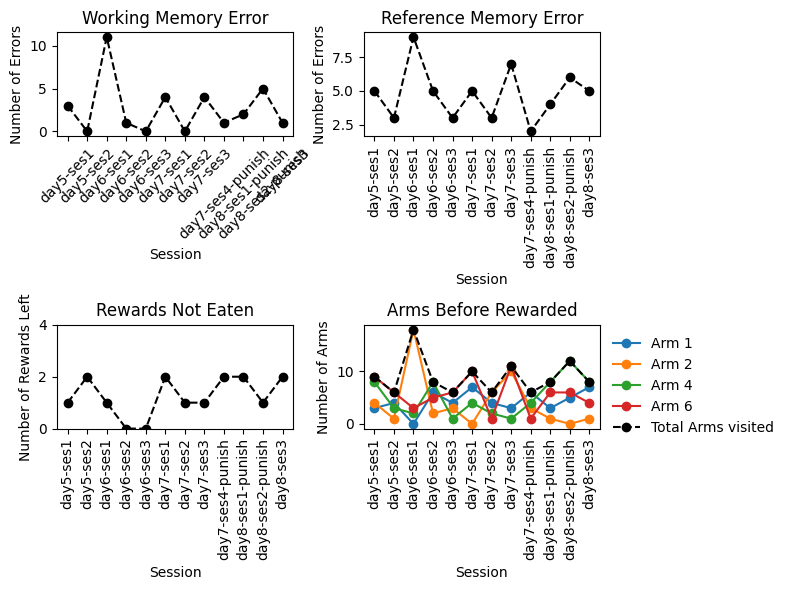

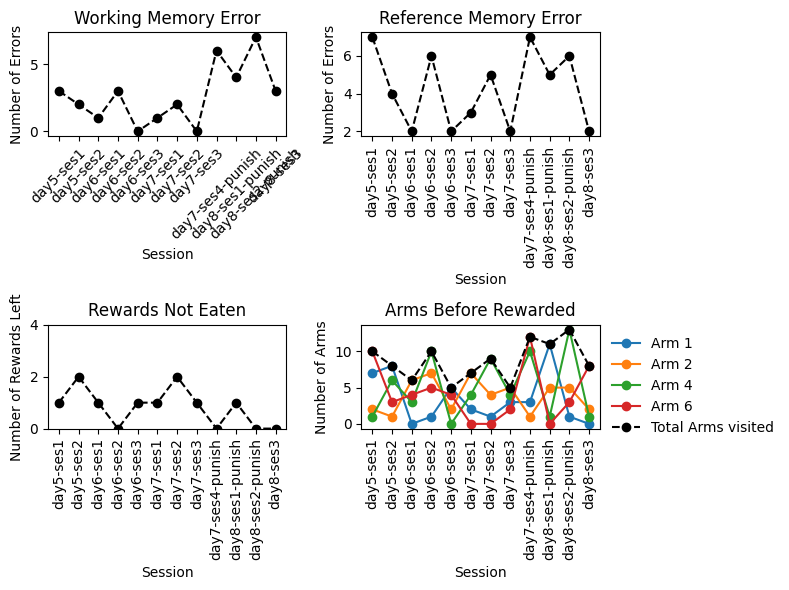

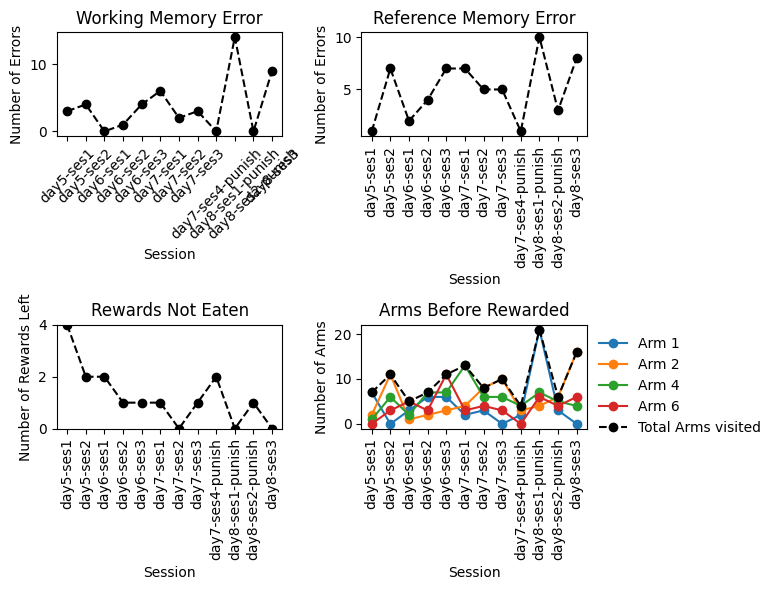

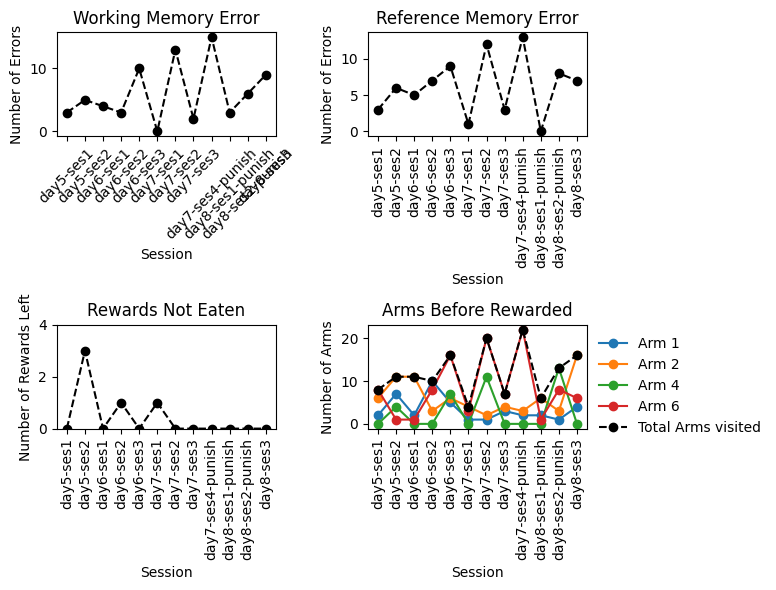

In [14]:
# for each mouse, calculate the working memory error, reference memory error, rewards eaten and arms before rewarded and plot

for mouse_id in mouse_ids:
    fig, ax = plt.subplots(2,2, figsize=(8,6))
    ax = ax.flatten()
    
    # plot working memory error
    wme = []
    for i,ses in enumerate(session_names):
        if arm_sequences[mouse_id][ses] is not None:
            sequence = arm_sequences[mouse_id][ses]
            wme.append(working_memory_error(sequence))
        else:
            wme.append(np.nan)
    ax[0].plot(np.arange(len(wme)), wme, marker='o', linestyle='--', color='black')
    ax[0].set_title('Working Memory Error')
    ax[0].set_ylabel('Number of Errors')
    ax[0].set_xlabel('Session')
    ax[0].set_xticks(np.arange(len(session_names)))
    ax[0].set_xticklabels(session_names, rotation=45)

    # plot reference memory error
    rme = []
    for i,ses in enumerate(session_names):
        if arm_sequences[mouse_id][ses] is not None:
            sequence = arm_sequences[mouse_id][ses]
            rme.append(reference_memory_error(sequence, rewarded_arms))
        else:
            rme.append(np.nan)
    ax[1].plot(np.arange(len(rme)), rme, marker='o', linestyle='--', color='black')
    ax[1].set_title('Reference Memory Error')
    ax[1].set_ylabel('Number of Errors')
    ax[1].set_xlabel('Session')
    ax[1].set_xticks(np.arange(len(session_names)))
    ax[1].set_xticklabels(session_names, rotation=90)

    # plot rewards eaten
    re = []
    for i in range(len(all_rewards)):
        re.append(4-all_rewards[i][all_rewards[i]['Subject'] == mouse_id].values[0][-4:].astype(int).sum())
    ax[2].plot(np.arange(len(re)), re, marker='o', linestyle='--', color='black')
    ax[2].set_title('Rewards Not Eaten')
    ax[2].set_ylabel('Number of Rewards Left')
    ax[2].set_xlabel('Session')
    ax[2].set_xticks(np.arange(len(session_names)))
    ax[2].set_xticklabels(session_names, rotation=90)
    ax[2].set_ylim(0, 4)

    
    # plot arms before rewarded
    abr = []
    for i,ses in enumerate(session_names):
        if arm_sequences[mouse_id][ses] is not None:
            sequence = arm_sequences[mouse_id][ses]
            abr.append(arms_before_rewarded(sequence, rewarded_arms))
        else:
            abr.append([np.nan]*len(rewarded_arms))
    abr = np.array(abr)
    for i in range(len(rewarded_arms)):
        ax[3].plot(np.arange(len(abr)), abr[:,i], marker='o', linestyle='-', label=f'Arm {rewarded_arms[i]}')
    # also plot the maximum number of arms
    ax[3].plot(np.arange(len(abr)), np.max(abr, axis=1), marker='o', linestyle='--', label='Total Arms visited', color='black')
    ax[3].set_title('Arms Before Rewarded')
    ax[3].set_ylabel('Number of Arms')
    ax[3].set_xlabel('Session')
    ax[3].set_xticks(np.arange(len(session_names)))
    ax[3].set_xticklabels(session_names, rotation=90)
    ax[3].legend(frameon=False, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    # save the figure
    plt.savefig(f'../processed_data/pilot_data/{mouse_id}_learning.png')
    plt.show()



